In [1]:
%%capture
# Cell 1: Install dependencies
%pip install -q --root-user-action=ignore "numpy==1.26.4" "scipy==1.13.1" "ultralytics==8.3.49" "filterpy==1.4.5" "seaborn"

import os, math, time, glob, cv2, random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from datetime import datetime
from ultralytics import YOLO
from filterpy.kalman import KalmanFilter
from scipy.optimize import linear_sum_assignment
from collections import defaultdict

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
print("All dependencies loaded!")

In [2]:
# Cell 2: Paths and sequence definitions
BASE_DIR = "/kaggle/input/adspmini02"
TRAIN_VIDEO_DIR = os.path.join(BASE_DIR, "Train", "vedios")
TRAIN_GT_DIR = os.path.join(BASE_DIR, "Train", "gt")
TEST_VIDEO_DIR = os.path.join(BASE_DIR, "Test", "vedios")
TEST_GT_DIR = os.path.join(BASE_DIR, "Test", "gt")
OUTPUT_DIR = "/kaggle/working/wildlife_tracking"
YOLO_BASE = "/kaggle/working/yolo_data"
RUN_ROOT = "/kaggle/working"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(YOLO_BASE, exist_ok=True)

def build_sequences(video_dir, gt_dir):
    seqs = {}
    if os.path.exists(video_dir):
        for pattern in ("*.mp4", "*.avi", "*.mov"):
            for vpath in sorted(glob.glob(os.path.join(video_dir, pattern))):
                base = os.path.splitext(os.path.basename(vpath))[0]
                seqs.setdefault(base, {})["video"] = vpath
    if os.path.exists(gt_dir):
        for gpath in sorted(glob.glob(os.path.join(gt_dir, "*.txt"))):
            base = os.path.splitext(os.path.basename(gpath))[0]
            if base.endswith("_gt"): base = base[:-3]
            seqs.setdefault(base, {})["gt"] = gpath
    for k, v in seqs.items():
        v.setdefault("video", None)
        v.setdefault("gt", None)
    return seqs

train_seqs = build_sequences(TRAIN_VIDEO_DIR, TRAIN_GT_DIR)
test_seqs = build_sequences(TEST_VIDEO_DIR, TEST_GT_DIR)
print(f"Train: {len(train_seqs)} sequences | Test: {len(test_seqs)} sequences")

Train: 14 sequences | Test: 5 sequences


In [3]:
# Cell 3: GT loader and class discovery
def load_gt_file(gt_path):
    cols = ["frame", "gt_id", "x", "y", "w", "h", "conf", "cls", "vis"]
    df = pd.read_csv(gt_path, header=None, names=cols, sep=r"[,\s]+", engine="python")
    df = df[["frame", "gt_id", "x", "y", "w", "h", "cls"]].copy()
    df["frame"] = df["frame"].astype(int)
    df["gt_id"] = df["gt_id"].astype(int)
    df["cls"] = df["cls"].astype(int)
    return df

ALL_CLASSES = set()
for seqs in (train_seqs, test_seqs):
    for seq_name, paths in seqs.items():
        gpath = paths.get("gt")
        if gpath and os.path.exists(gpath):
            df = load_gt_file(gpath)
            if not df.empty: ALL_CLASSES.update(df["cls"].unique().tolist())

ALL_CLASSES = sorted(int(c) for c in ALL_CLASSES)
cls_to_new = {old: i for i, old in enumerate(ALL_CLASSES)}
NC = len(ALL_CLASSES)
print(f"Classes: {ALL_CLASSES} | Remap: {cls_to_new}")

Classes: [2, 6, 8] | Remap: {2: 0, 6: 1, 8: 2}


In [4]:
# Cell 4: Export Train/Test to YOLO format
IMGS_TRAIN_DIR = os.path.join(YOLO_BASE, "images", "train")
IMGS_VAL_DIR = os.path.join(YOLO_BASE, "images", "val")
LBL_TRAIN_DIR = os.path.join(YOLO_BASE, "labels", "train")
LBL_VAL_DIR = os.path.join(YOLO_BASE, "labels", "val")
for d in [IMGS_TRAIN_DIR, IMGS_VAL_DIR, LBL_TRAIN_DIR, LBL_VAL_DIR]: os.makedirs(d, exist_ok=True)

def export_split_to_yolo(split_name, seq_dict, img_out_dir, lbl_out_dir):
    print(f"\nExporting {split_name}...")
    for seq_name, paths in seq_dict.items():
        video_path, gt_path = paths["video"], paths["gt"]
        if not video_path or not gt_path: continue
        gt_df = load_gt_file(gt_path)
        if gt_df.empty: continue
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened(): continue
        w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frame_idx = 0
        while True:
            ret, frame = cap.read()
            if not ret: break
            frame_idx += 1
            sub = gt_df[gt_df["frame"] == frame_idx]
            if sub.empty: continue
            img_name = f"{seq_name}_{frame_idx:06d}.jpg"
            cv2.imwrite(os.path.join(img_out_dir, img_name), frame)
            lines = []
            for _, row in sub.iterrows():
                x, y, bw, bh = row["x"], row["y"], row["w"], row["h"]
                cls_new = cls_to_new[int(row["cls"])]
                xc, yc = (x + bw/2)/w, (y + bh/2)/h
                lines.append(f"{cls_new} {xc:.6f} {yc:.6f} {bw/w:.6f} {bh/h:.6f}")
            with open(os.path.join(lbl_out_dir, img_name.replace(".jpg", ".txt")), "w") as f:
                f.write("\n".join(lines))
        cap.release()
        print(f"  Done: {seq_name}")

export_split_to_yolo("Train", train_seqs, IMGS_TRAIN_DIR, LBL_TRAIN_DIR)
export_split_to_yolo("Test", test_seqs, IMGS_VAL_DIR, LBL_VAL_DIR)
print("\nYOLO export done.")


Exporting Train...
  Done: deer_1
  Done: deer_2
  Done: deer_3
  Done: deer_4
  Done: deer_7
  Done: horse_3
  Done: horse_4
  Done: horse_5
  Done: horse_6
  Done: horse_7
  Done: pig_1
  Done: pig_2
  Done: pig_3
  Done: pig_5

Exporting Test...
  Done: deer_5
  Done: deer_6
  Done: horse_1
  Done: horse_2
  Done: pig_4

YOLO export done.


In [5]:
# Cell 5: Create data.yaml
names_list = [f"cls{c}" for c in ALL_CLASSES]
data_yaml = f"""path: {YOLO_BASE}
train: images/train
val: images/val
nc: {NC}
names: {names_list}
"""
yaml_path = os.path.join(YOLO_BASE, "data.yaml")
with open(yaml_path, "w") as f: f.write(data_yaml)
print("data.yaml created")

data.yaml created


In [6]:
# Cell 6: Fix Ray Tune callback issue
import ultralytics.utils.callbacks.raytune as raytune_callbacks
raytune_callbacks.callbacks = {}
print("Ray Tune callbacks disabled - compatibility fix applied")

Ray Tune callbacks disabled - compatibility fix applied


In [7]:
# Cell 7: Train YOLO
det_model = YOLO("yolov8n.pt")
results = det_model.train(data=yaml_path, imgsz=640, epochs=20, batch=64, name="wildlife_det", exist_ok=True)
try: save_dir = det_model.trainer.save_dir
except: save_dir = os.path.join(RUN_ROOT, "runs", "detect", "wildlife_det")
print(f"\nTraining done. Save dir: {save_dir}")

Throwing away 54894 bytes
######################################################################## 100.0%
100%|██████████| 755k/755k [00:00<00:00, 114MB/s]
E0000 00:00:1765469146.285260      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765469146.334450      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

100%|██████████| 5.35M/5.35M [00:00<00:00, 354MB/s]
train: Scanning /kaggle/working/yolo_data/labels/train... 6430 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6430/6430 [00:04<00:00, 1397.90it/s]
/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /kaggle/working/yolo_data/labels/val... 1442 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1442/1442 [00:02<00:00, 541.17it/s]
       1/20      10.3G      1.264      1.642      1.155        704        640: 100%|██████████| 101/101 [01:48<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:17<00:00,  1.46s/it]
       2/20      12.7G      1.052     0.7693      1.052       1002        640: 100%|██████████| 101/101 [01:35<00:00,  1.05it/s]
                 Class     Images  Instances    


Training done. Save dir: runs/detect/wildlife_det


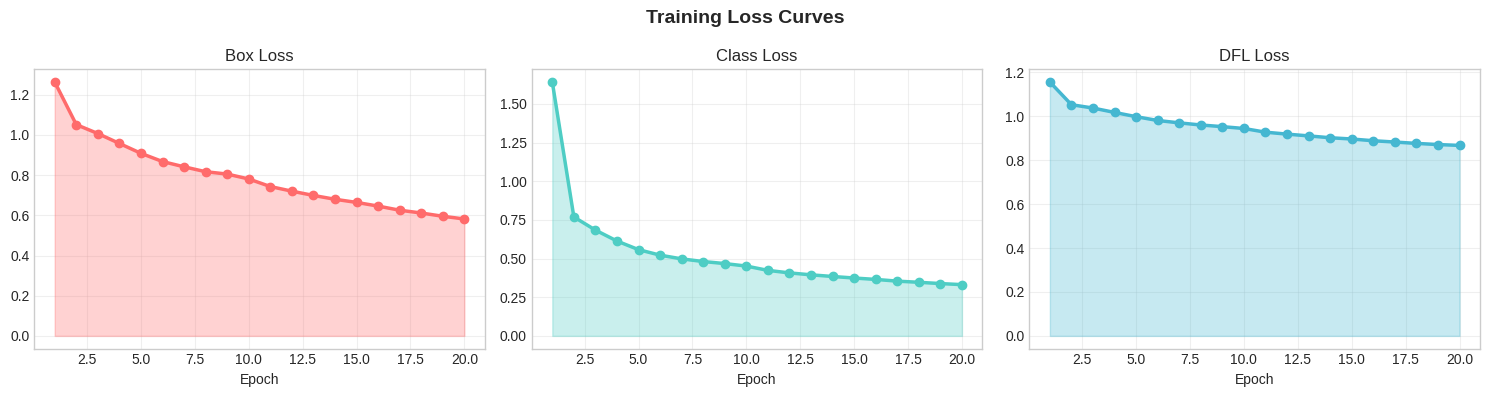

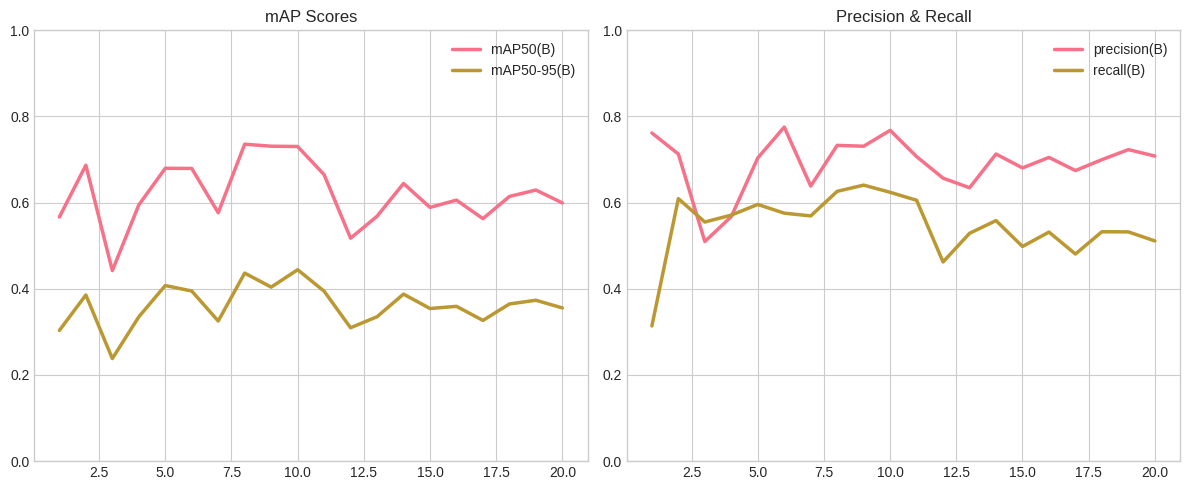

Best Epoch: 8 | mAP50: 0.7357


In [8]:
# Cell 8: Training Visualization
results_csv = os.path.join(save_dir, "results.csv") if save_dir else None
if results_csv and os.path.exists(results_csv):
    df = pd.read_csv(results_csv)
    df.columns = [c.strip() for c in df.columns]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle('Training Loss Curves', fontsize=14, fontweight='bold')
    loss_cols = [('train/box_loss', 'Box Loss', '#FF6B6B'), ('train/cls_loss', 'Class Loss', '#4ECDC4'), ('train/dfl_loss', 'DFL Loss', '#45B7D1')]
    for idx, (col, name, color) in enumerate(loss_cols):
        if col in df.columns:
            axes[idx].plot(df['epoch'], df[col], color=color, linewidth=2.5, marker='o')
            axes[idx].fill_between(df['epoch'], df[col], alpha=0.3, color=color)
            axes[idx].set_title(name); axes[idx].set_xlabel('Epoch'); axes[idx].grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'losses.png'), dpi=150); plt.show()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    map_cols = [c for c in df.columns if 'mAP' in c]
    for col in map_cols[:2]: axes[0].plot(df['epoch'], df[col], label=col.replace('metrics/', ''), linewidth=2.5)
    axes[0].set_title('mAP Scores'); axes[0].legend(); axes[0].set_ylim(0, 1)
    pr_cols = [c for c in df.columns if 'precision' in c.lower() or 'recall' in c.lower()]
    for col in pr_cols[:2]: axes[1].plot(df['epoch'], df[col], label=col.replace('metrics/', ''), linewidth=2.5)
    axes[1].set_title('Precision & Recall'); axes[1].legend(); axes[1].set_ylim(0, 1)
    plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'metrics.png'), dpi=150); plt.show()
    
    best_col = 'metrics/mAP50(B)' if 'metrics/mAP50(B)' in df.columns else None
    if best_col:
        best_row = df.loc[df[best_col].idxmax()]
        print(f"Best Epoch: {int(best_row['epoch'])} | mAP50: {best_row[best_col]:.4f}")

In [9]:
# Cell 9: Enhanced Multi-Object Tracker with Trajectory Support
class Track:
    """
    Represents a tracked object using Kalman Filter.
    State: [x, y, area, aspect_ratio, vx, vy, v_area]
    Features: Trajectory history, occlusion handling, track quality metrics
    """
    _next_id = 1
    
    def __init__(self, track_id, detection, cls):
        self.track_id = track_id
        self.cls = cls
        self.hits = 1
        self.misses = 0
        self.consecutive_misses = 0
        self.age = 1
        self.time_since_update = 0
        
        # Trajectory for visualization
        self.trajectory = []
        self.max_trajectory_length = 50
        
        # Occlusion tracking
        self.occlusion_count = 0
        self.total_occlusion_frames = 0
        self.currently_occluded = False
        
        # Track lifetime
        self.first_frame = None
        self.last_frame = None
        self.total_visible_frames = 0
        
        # Kalman Filter
        self.kf = KalmanFilter(dim_x=7, dim_z=4)
        self.kf.F = np.array([[1,0,0,0,1,0,0],[0,1,0,0,0,1,0],[0,0,1,0,0,0,1],[0,0,0,1,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])
        self.kf.H = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0]])
        self.kf.R *= 10.0
        self.kf.P[4:, 4:] *= 1000.0
        self.kf.P *= 10.0
        self.kf.Q[-1, -1] *= 0.01
        self.kf.Q[4:, 4:] *= 0.01
        
        x1, y1, x2, y2 = detection
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
        w, h = x2 - x1, y2 - y1
        area = w * h
        aspect = w / (h + 1e-6)
        self.kf.x[:4] = np.array([[cx], [cy], [area], [aspect]])
        self.trajectory.append((int(cx), int(cy)))
    
    def predict(self):
        if self.kf.x[2] + self.kf.x[6] <= 0: self.kf.x[6] *= 0.0
        self.kf.predict()
        self.age += 1
        self.time_since_update += 1
        return self.get_state()
    
    def update(self, detection, current_frame=None):
        x1, y1, x2, y2 = detection
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
        w, h = x2 - x1, y2 - y1
        self.kf.update(np.array([[cx], [cy], [w * h], [w / (h + 1e-6)]]))
        self.hits += 1
        self.misses = 0
        if self.consecutive_misses > 0: self.currently_occluded = False
        self.consecutive_misses = 0
        self.time_since_update = 0
        self.trajectory.append((int(cx), int(cy)))
        if len(self.trajectory) > self.max_trajectory_length: self.trajectory.pop(0)
        if current_frame:
            if self.first_frame is None: self.first_frame = current_frame
            self.last_frame = current_frame
            self.total_visible_frames += 1
    
    def mark_missed(self):
        self.misses += 1
        self.consecutive_misses += 1
        if self.consecutive_misses >= 3 and not self.currently_occluded:
            self.currently_occluded = True
            self.occlusion_count += 1
        if self.currently_occluded: self.total_occlusion_frames += 1
    
    def get_state(self):
        cx, cy, area, aspect = self.kf.x[:4].flatten()
        w = np.sqrt(area * aspect)
        h = area / (w + 1e-6)
        return np.array([cx - w/2, cy - h/2, cx + w/2, cy + h/2])


class MultiObjectTracker:
    """
    Multi-Object Tracker using Kalman Filter + Hungarian Algorithm.
    Pipeline: PREDICT -> MATCH -> UPDATE -> CREATE -> DELETE
    """
    def __init__(self, max_misses=30, iou_thresh=0.3):
        self.tracks = []
        self.max_misses = max_misses
        self.iou_thresh = iou_thresh
        self.next_id = 1
        self.total_detections = 0
        self.total_matches = 0
        self.total_new_tracks = 0
        self.total_lost_tracks = 0
        self.frame_times = []
    
    def _iou(self, boxA, boxB):
        xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
        xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])
        inter = max(0, xB - xA) * max(0, yB - yA)
        return inter / ((boxA[2]-boxA[0])*(boxA[3]-boxA[1]) + (boxB[2]-boxB[0])*(boxB[3]-boxB[1]) - inter + 1e-6)
    
    def update(self, detections, classes, current_frame=None):
        start_time = time.time()
        self.total_detections += len(detections)
        for track in self.tracks: track.predict()
        
        if len(self.tracks) > 0 and len(detections) > 0:
            cost_matrix = np.zeros((len(self.tracks), len(detections)))
            for t, track in enumerate(self.tracks):
                for d, det in enumerate(detections):
                    cost_matrix[t, d] = 1 - self._iou(track.get_state(), det)
            row_idx, col_idx = linear_sum_assignment(cost_matrix)
            matched_tracks, matched_dets = set(), set()
            for row, col in zip(row_idx, col_idx):
                if cost_matrix[row, col] < (1 - self.iou_thresh):
                    self.tracks[row].update(detections[col], current_frame)
                    matched_tracks.add(row)
                    matched_dets.add(col)
                    self.total_matches += 1
            for t in range(len(self.tracks)):
                if t not in matched_tracks: self.tracks[t].mark_missed()
            for d in range(len(detections)):
                if d not in matched_dets:
                    new_track = Track(self.next_id, detections[d], classes[d])
                    new_track.first_frame = current_frame
                    self.tracks.append(new_track)
                    self.next_id += 1
                    self.total_new_tracks += 1
        elif len(detections) > 0:
            for d, det in enumerate(detections):
                new_track = Track(self.next_id, det, classes[d])
                new_track.first_frame = current_frame
                self.tracks.append(new_track)
                self.next_id += 1
                self.total_new_tracks += 1
        else:
            for track in self.tracks: track.mark_missed()
        
        self.tracks = [t for t in self.tracks if t.misses <= self.max_misses]
        self.frame_times.append(time.time() - start_time)
        return self.tracks
    
    def get_performance_stats(self):
        avg_time = np.mean(self.frame_times) if self.frame_times else 0
        return {'total_detections': self.total_detections, 'total_matches': self.total_matches,
                'total_new_tracks': self.total_new_tracks, 'total_lost_tracks': self.total_lost_tracks,
                'avg_frame_time': avg_time, 'tracking_fps': 1.0/avg_time if avg_time > 0 else 0}

print("Tracker classes defined!")

Tracker classes defined!


In [10]:
# Cell 10: Class Names
CLASS_NAMES = {0: 'deer', 1: 'horse', 2: 'pig'}

In [11]:
# Cell 11: Run Tracker with Trajectory Visualization and FPS Measurement
all_tracks_records = []
performance_records = []

def run_on_split(split_name, seq_dict):
    print(f"\n{'='*60}\nProcessing {split_name} sequences\n{'='*60}")
    for seq_name, paths in seq_dict.items():
        video_path = paths.get("video")
        if not video_path or not os.path.exists(video_path): continue
        print(f"\nProcessing: {seq_name}")
        tracker = MultiObjectTracker(max_misses=30, iou_thresh=0.3)
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened(): continue
        fps = cap.get(cv2.CAP_PROP_FPS)
        w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        out_path = os.path.join(OUTPUT_DIR, f"{split_name}_{seq_name}_tracked.mp4")
        out_writer = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))
        colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255),(128,0,128),(255,165,0),(0,128,128),(128,128,0)]
        frame_idx = 0
        processing_times = []
        while True:
            ret, frame = cap.read()
            if not ret: break
            frame_idx += 1
            start_time = time.time()
            results = det_model.predict(source=frame, imgsz=640, conf=0.4, verbose=False)
            detections, det_classes = [], []
            for r in results:
                if r.boxes is None: continue
                for box in r.boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    detections.append([x1, y1, x2, y2])
                    det_classes.append(int(box.cls))
            tracks = tracker.update(detections, det_classes, frame_idx)
            processing_time = time.time() - start_time
            processing_times.append(processing_time)
            for track in tracks:
                if track.misses > 0: continue
                color = colors[track.track_id % len(colors)]
                x1, y1, x2, y2 = map(int, track.get_state())
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 3)
                cv2.putText(frame, f"{CLASS_NAMES.get(track.cls, 'unk')} ID:{track.track_id}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
                # Draw trajectory lines
                if len(track.trajectory) > 1:
                    for i in range(1, len(track.trajectory)):
                        thickness = max(1, int(3 * i / len(track.trajectory)))
                        cv2.line(frame, track.trajectory[i-1], track.trajectory[i], color, thickness)
                all_tracks_records.append({"split": split_name, "seq": seq_name, "frame": frame_idx,
                    "track_id": track.track_id, "cls": track.cls, "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                    "hits": track.hits, "misses": track.misses, "occlusions": track.occlusion_count})
            current_fps = 1.0 / processing_time if processing_time > 0 else 0
            cv2.putText(frame, f"FPS: {current_fps:.1f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(frame, f"Tracks: {len([t for t in tracks if t.misses == 0])}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            out_writer.write(frame)
        cap.release()
        out_writer.release()
        avg_fps = 1.0 / np.mean(processing_times) if processing_times else 0
        stats = tracker.get_performance_stats()
        performance_records.append({"split": split_name, "seq": seq_name, "total_frames": total_frames,
            "avg_processing_fps": avg_fps, "total_tracks_created": stats['total_new_tracks']})
        print(f"  Saved: {out_path}\n  Performance: {avg_fps:.1f} FPS")

run_on_split("Train", train_seqs)
run_on_split("Test", test_seqs)

tracks_df = pd.DataFrame(all_tracks_records)
tracks_df.to_csv(os.path.join(OUTPUT_DIR, "tracks.csv"), index=False)
performance_df = pd.DataFrame(performance_records)
performance_df.to_csv(os.path.join(OUTPUT_DIR, "performance.csv"), index=False)
print(f"\nSaved tracks.csv ({len(tracks_df)} records) and performance.csv")


Processing Train sequences

Processing: deer_1
  Saved: /kaggle/working/wildlife_tracking/Train_deer_1_tracked.mp4
  Performance: 71.2 FPS

Processing: deer_2
  Saved: /kaggle/working/wildlife_tracking/Train_deer_2_tracked.mp4
  Performance: 45.2 FPS

Processing: deer_3
  Saved: /kaggle/working/wildlife_tracking/Train_deer_3_tracked.mp4
  Performance: 56.2 FPS

Processing: deer_4
  Saved: /kaggle/working/wildlife_tracking/Train_deer_4_tracked.mp4
  Performance: 71.6 FPS

Processing: deer_7
  Saved: /kaggle/working/wildlife_tracking/Train_deer_7_tracked.mp4
  Performance: 56.0 FPS

Processing: horse_3
  Saved: /kaggle/working/wildlife_tracking/Train_horse_3_tracked.mp4
  Performance: 64.5 FPS

Processing: horse_4
  Saved: /kaggle/working/wildlife_tracking/Train_horse_4_tracked.mp4
  Performance: 55.8 FPS

Processing: horse_5
  Saved: /kaggle/working/wildlife_tracking/Train_horse_5_tracked.mp4
  Performance: 57.0 FPS

Processing: horse_6
  Saved: /kaggle/working/wildlife_tracking/Train_

In [12]:
# Cell 12: Comprehensive Tracking Evaluation
def bbox_iou(a, b):
    ix1, iy1 = max(a[0], b[0]), max(a[1], b[1])
    ix2, iy2 = min(a[2], b[2]), min(a[3], b[3])
    inter = max(0, ix2-ix1) * max(0, iy2-iy1)
    return inter / ((a[2]-a[0])*(a[3]-a[1]) + (b[2]-b[0])*(b[3]-b[1]) - inter + 1e-6)

def evaluate_sequence(seq_name, split_name, gt_path, tracks_df, iou_thresh=0.5):
    gt_df = load_gt_file(gt_path)
    if gt_df.empty: return None
    sub = tracks_df[(tracks_df["split"]==split_name) & (tracks_df["seq"]==seq_name)]
    if sub.empty: return None
    track_map, total_gt, total_pred, matches, id_switches = {}, 0, 0, 0, 0
    gt_appearances, gt_tracked = defaultdict(int), defaultdict(int)
    for f in sorted(gt_df["frame"].unique()):
        gt_f, tr_f = gt_df[gt_df["frame"]==f], sub[sub["frame"]==f]
        gt_boxes, gt_ids = gt_f[["x","y","w","h"]].values, gt_f["gt_id"].values
        pred_boxes, pred_ids = tr_f[["x1","y1","x2","y2"]].values, tr_f["track_id"].values
        total_gt += len(gt_boxes); total_pred += len(pred_boxes)
        for gid in gt_ids: gt_appearances[gid] += 1
        if len(gt_boxes)==0 or len(pred_boxes)==0: continue
        cost = np.zeros((len(gt_boxes), len(pred_boxes)))
        for i in range(len(gt_boxes)):
            x,y,w,h = gt_boxes[i]
            for j in range(len(pred_boxes)): cost[i,j] = 1.0 - bbox_iou((x,y,x+w,y+h), tuple(pred_boxes[j]))
        row_idx, col_idx = linear_sum_assignment(cost)
        for r, c in zip(row_idx, col_idx):
            if 1.0-cost[r,c] >= iou_thresh:
                gid, tid = int(gt_ids[r]), int(pred_ids[c])
                matches += 1; gt_tracked[gid] += 1
                if gid in track_map and track_map[gid] != tid: id_switches += 1
                track_map[gid] = tid
    fp, fn = max(0, total_pred-matches), max(0, total_gt-matches)
    track_durations = [gt_tracked[gid]/gt_appearances[gid]*100 if gid in gt_tracked else 0 for gid in gt_appearances]
    return {"split": split_name, "seq": seq_name, "gt": total_gt, "pred": total_pred, "matches": matches,
            "FP": fp, "FN": fn, "IDsw": id_switches, "MOTA": 1-(fp+fn+id_switches)/(total_gt+1e-6),
            "precision": matches/(total_pred+1e-6), "recall": matches/(total_gt+1e-6),
            "avg_track_duration_pct": np.mean(track_durations) if track_durations else 0,
            "mostly_tracked": sum(1 for d in track_durations if d >= 80),
            "mostly_lost": sum(1 for d in track_durations if d <= 20),
            "total_objects": len(gt_appearances)}

results = []
for split_name, seq_dict in [("Train", train_seqs), ("Test", test_seqs)]:
    for seq_name, paths in seq_dict.items():
        if paths["gt"] and os.path.exists(paths["gt"]):
            res = evaluate_sequence(seq_name, split_name, paths["gt"], tracks_df)
            if res: results.append(res)

metrics_df = pd.DataFrame(results)
metrics_df.to_csv(os.path.join(OUTPUT_DIR, "tracking_metrics.csv"), index=False)
display(metrics_df)

split      seq     gt   pred  matches    FP    FN  IDsw      MOTA  \
0   Train   deer_1   2412   2259     2202    57   210    78  0.856965   
1   Train   deer_2   7214   7247     6899   348   315    78  0.897283   
2   Train   deer_3   4861   4787     4676   111   185    23  0.934376   
3   Train   deer_4   2462   2572     2408   164    54    17  0.904549   
4   Train   deer_7   4989   5114     4902   212    87    23  0.935458   
5   Train  horse_3  15930  16093    15408   685   522    94  0.918330   
6   Train  horse_4   3731   3722     3694    28    37     1  0.982310   
7   Train  horse_5   5603   5473     5393    80   210    19  0.944851   
8   Train  horse_6   7879   7890     7699   191   180    71  0.943902   
9   Train  horse_7  10091  10041     9857   184   234    44  0.954217   
10  Train    pig_1   2623   2841     2543   298    80    76  0.826916   
11  Train    pig_2  10854  11865    10616  1249   238   117  0.852220   
12  Train    pig_3   6761   6934     6696   238    65    16  0.952818   
13  Train    pig_5   5468   5845     5194   651   274   104  0.811814   
14   Test   deer_5   1771    413      260   153  1511     5  0.057595   
15   Test   deer_6  14815  10345     9767   578  5048    83  0.614647   
16   Test  horse_1   6653   5323     4854   469  1799   192  0.630242   
17   Test  horse_2   5815   2707     2636    71  3179    68  0.429407   
18   Test    pig_4   6567   3602     3329   273  3238    32  0.460484   

    precision    recall  avg_track_duration_pct  mostly_tracked  mostly_lost  \
0    0.974768  0.912935               90.775180               7            0   
1    0.951980  0.956335               94.961359              41            0   
2    0.976812  0.961942               94.292694              23            0   
3    0.936236  0.978067               97.871852              10            0   
4    0.958545  0.982562               92.462431              23            1   
5    0.957435  0.967232               94.071341              62            1   
6    0.992477  0.990083               96.937207              18            0   
7    0.985383  0.962520               96.400196              19            0   
8    0.975792  0.977154               96.808028              28            0   
9    0.981675  0.976811               95.005671              17            0   
10   0.895107  0.969501               95.854228              17            0   
11   0.894732  0.978073               97.012403              55            0   
12   0.965676  0.990386               98.662788              24            0   
13   0.888623  0.949890               93.016671              21            1   
14   0.629540  0.146810               17.482605               0            5   
15   0.944128  0.659264               65.485133              26            9   
16   0.911892  0.729596               69.064596              25            7   
17   0.973772  0.453310               36.968254               4           11   
18   0.924209  0.506929               51.759414              10            8   

    total_objects  
0               8  
1              44  
2              26  
3              10  
4              27  
5              68  
6              20  
7              20  
8              29  
9              19  
10             18  
11             57  
12             24  
13             23  
14              7  
15             50  
16             50  
17             37  
18             29

/tmp/ipykernel_47/1484176594.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_xticklabels(metrics_df['seq'], rotation=45)
/tmp/ipykernel_47/1484176594.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax7.set_xticklabels(performance_df['seq'], rotation=45)
/tmp/ipykernel_47/1484176594.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax8.set_xticklabels(metrics_df['seq'], rotation=45)


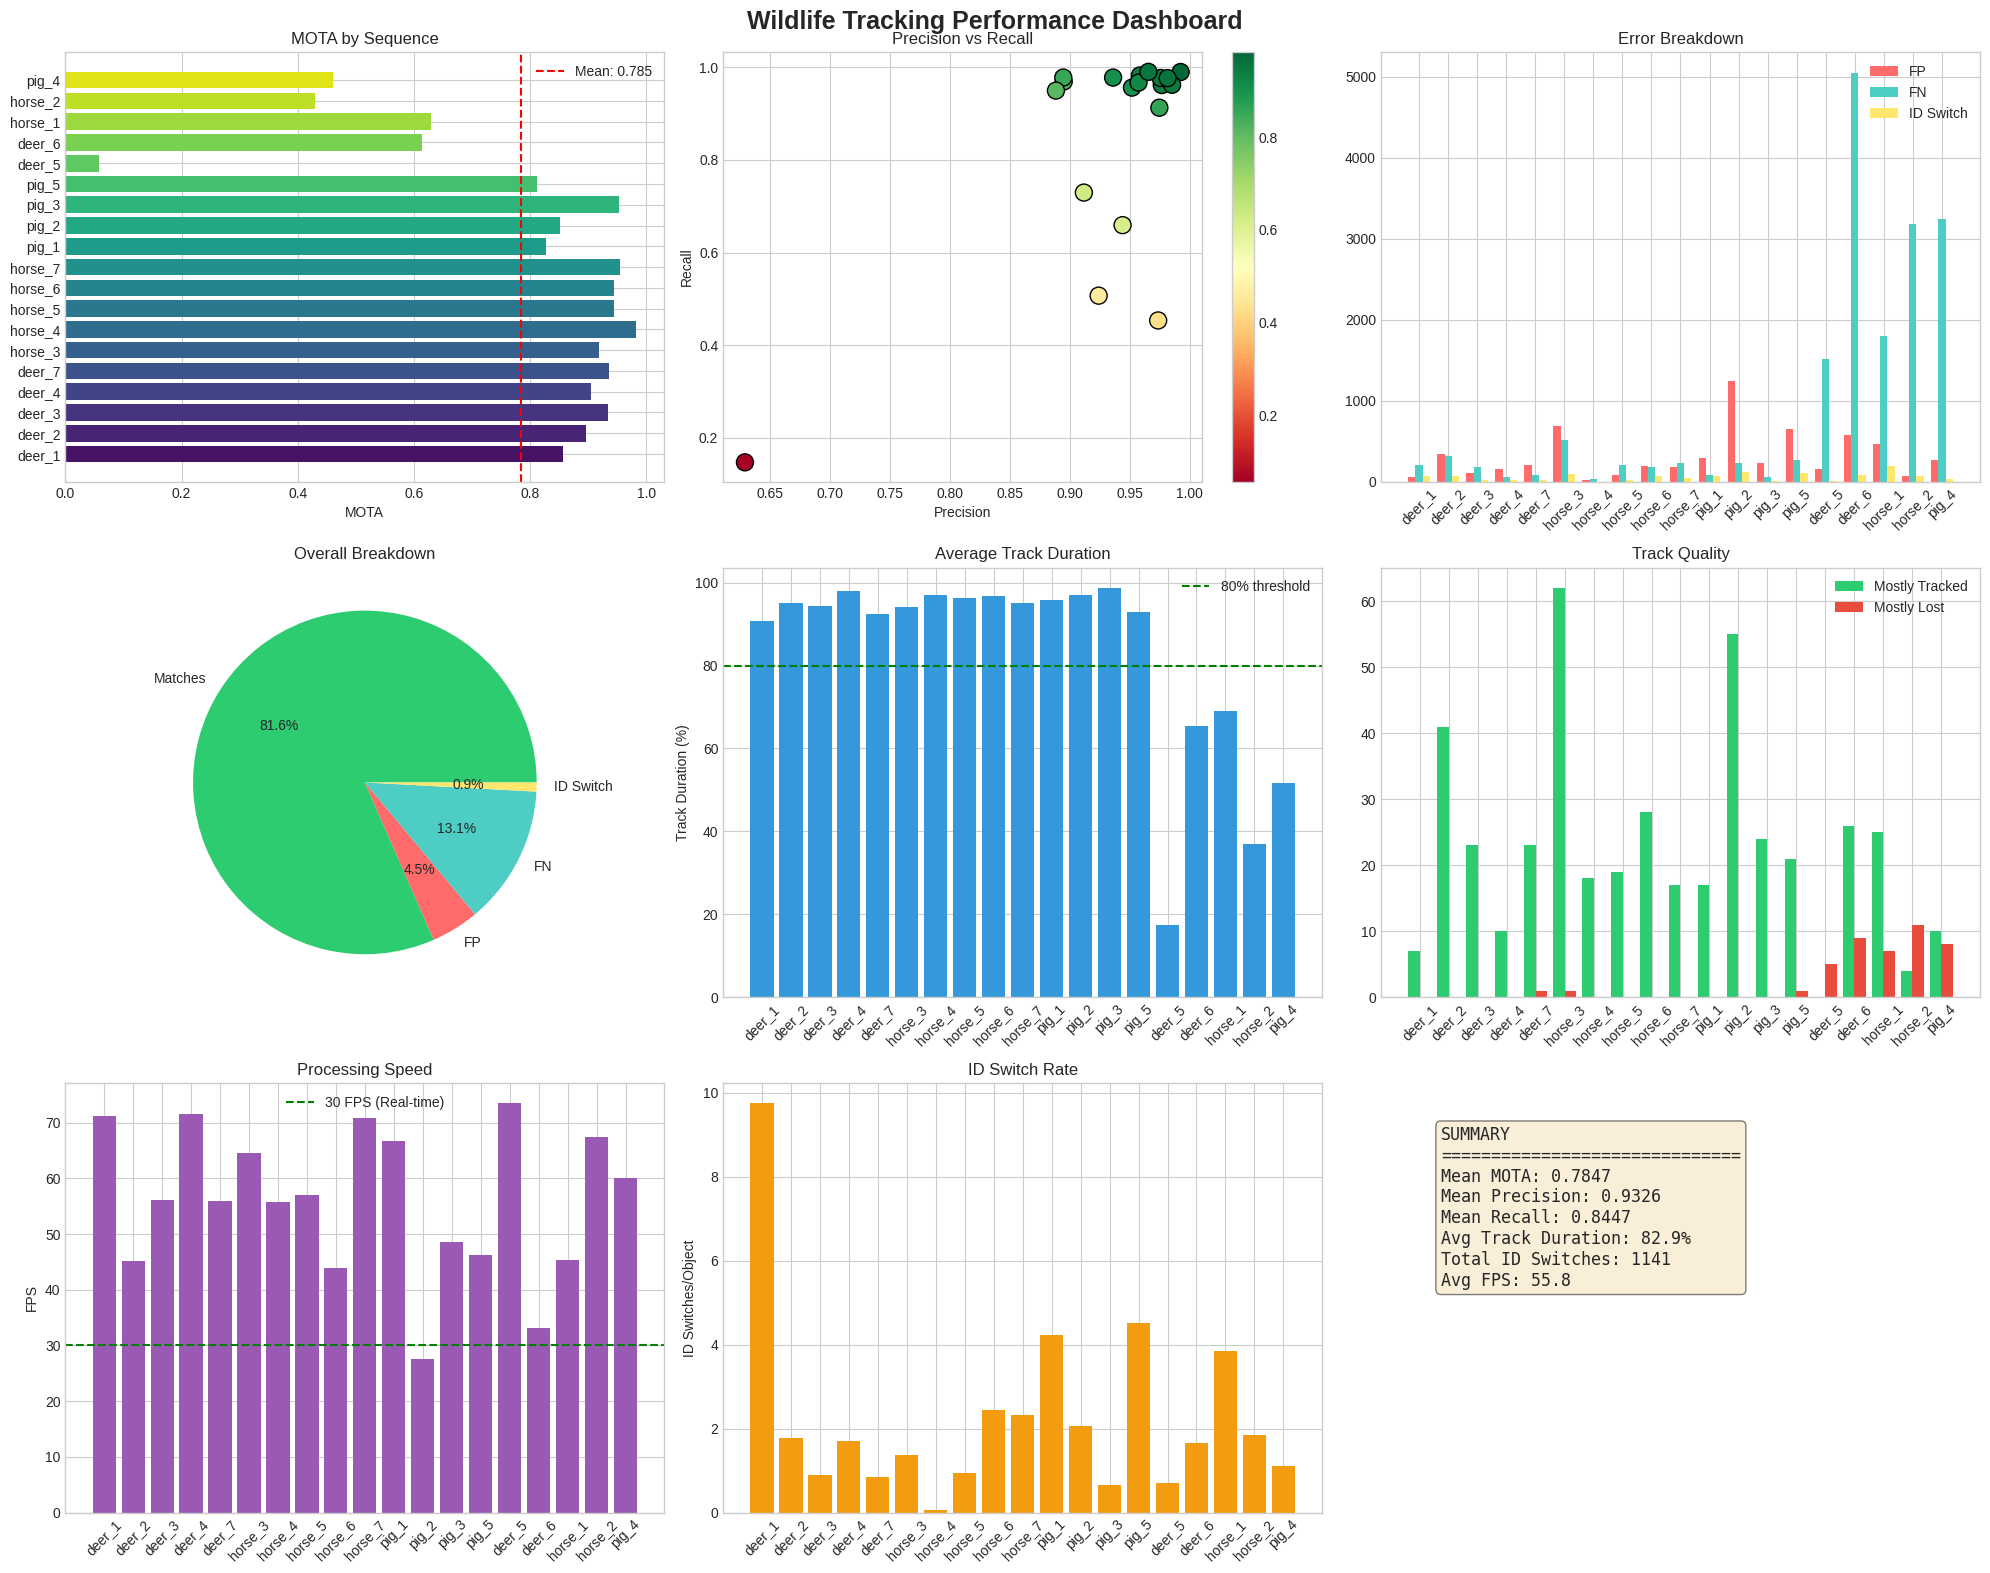

In [13]:
# Cell 13: Comprehensive Visualization Dashboard
if not metrics_df.empty:
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle('Wildlife Tracking Performance Dashboard', fontsize=18, fontweight='bold')
    
    ax1 = fig.add_subplot(3, 3, 1)
    ax1.barh(metrics_df['seq'], metrics_df['MOTA'], color=sns.color_palette('viridis', len(metrics_df)))
    ax1.axvline(x=metrics_df['MOTA'].mean(), color='red', linestyle='--', label=f"Mean: {metrics_df['MOTA'].mean():.3f}")
    ax1.set_xlabel('MOTA'); ax1.set_title('MOTA by Sequence'); ax1.legend()
    
    ax2 = fig.add_subplot(3, 3, 2)
    scatter = ax2.scatter(metrics_df['precision'], metrics_df['recall'], c=metrics_df['MOTA'], cmap='RdYlGn', s=150, edgecolors='black')
    ax2.set_xlabel('Precision'); ax2.set_ylabel('Recall'); ax2.set_title('Precision vs Recall'); plt.colorbar(scatter, ax=ax2)
    
    ax3 = fig.add_subplot(3, 3, 3)
    x = np.arange(len(metrics_df)); w = 0.25
    ax3.bar(x-w, metrics_df['FP'], w, label='FP', color='#FF6B6B')
    ax3.bar(x, metrics_df['FN'], w, label='FN', color='#4ECDC4')
    ax3.bar(x+w, metrics_df['IDsw'], w, label='ID Switch', color='#FFE66D')
    ax3.set_xticks(x); ax3.set_xticklabels(metrics_df['seq'], rotation=45); ax3.legend(); ax3.set_title('Error Breakdown')
    
    ax4 = fig.add_subplot(3, 3, 4)
    sizes = [metrics_df['matches'].sum(), metrics_df['FP'].sum(), metrics_df['FN'].sum(), metrics_df['IDsw'].sum()]
    ax4.pie(sizes, labels=['Matches', 'FP', 'FN', 'ID Switch'], colors=['#2ECC71','#FF6B6B','#4ECDC4','#FFE66D'], autopct='%1.1f%%')
    ax4.set_title('Overall Breakdown')
    
    ax5 = fig.add_subplot(3, 3, 5)
    ax5.bar(metrics_df['seq'], metrics_df['avg_track_duration_pct'], color='#3498DB')
    ax5.axhline(y=80, color='green', linestyle='--', label='80% threshold')
    ax5.set_ylabel('Track Duration (%)'); ax5.set_title('Average Track Duration'); ax5.legend()
    ax5.set_xticklabels(metrics_df['seq'], rotation=45)
    
    ax6 = fig.add_subplot(3, 3, 6)
    x = np.arange(len(metrics_df))
    ax6.bar(x-0.2, metrics_df['mostly_tracked'], 0.4, label='Mostly Tracked', color='#2ECC71')
    ax6.bar(x+0.2, metrics_df['mostly_lost'], 0.4, label='Mostly Lost', color='#E74C3C')
    ax6.set_xticks(x); ax6.set_xticklabels(metrics_df['seq'], rotation=45); ax6.legend(); ax6.set_title('Track Quality')
    
    if not performance_df.empty:
        ax7 = fig.add_subplot(3, 3, 7)
        ax7.bar(performance_df['seq'], performance_df['avg_processing_fps'], color='#9B59B6')
        ax7.axhline(y=30, color='green', linestyle='--', label='30 FPS (Real-time)')
        ax7.set_ylabel('FPS'); ax7.set_title('Processing Speed'); ax7.legend()
        ax7.set_xticklabels(performance_df['seq'], rotation=45)
    
    ax8 = fig.add_subplot(3, 3, 8)
    ax8.bar(metrics_df['seq'], metrics_df['IDsw']/(metrics_df['total_objects']+1e-6), color='#F39C12')
    ax8.set_ylabel('ID Switches/Object'); ax8.set_title('ID Switch Rate')
    ax8.set_xticklabels(metrics_df['seq'], rotation=45)
    
    ax9 = fig.add_subplot(3, 3, 9)
    ax9.axis('off')
    summary = f"""SUMMARY\n{'='*30}\nMean MOTA: {metrics_df['MOTA'].mean():.4f}\nMean Precision: {metrics_df['precision'].mean():.4f}\nMean Recall: {metrics_df['recall'].mean():.4f}\nAvg Track Duration: {metrics_df['avg_track_duration_pct'].mean():.1f}%\nTotal ID Switches: {metrics_df['IDsw'].sum()}\nAvg FPS: {performance_df['avg_processing_fps'].mean():.1f}"""
    ax9.text(0.1, 0.9, summary, transform=ax9.transAxes, fontsize=12, verticalalignment='top', fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, 'comprehensive_dashboard.png'), dpi=150); plt.show()

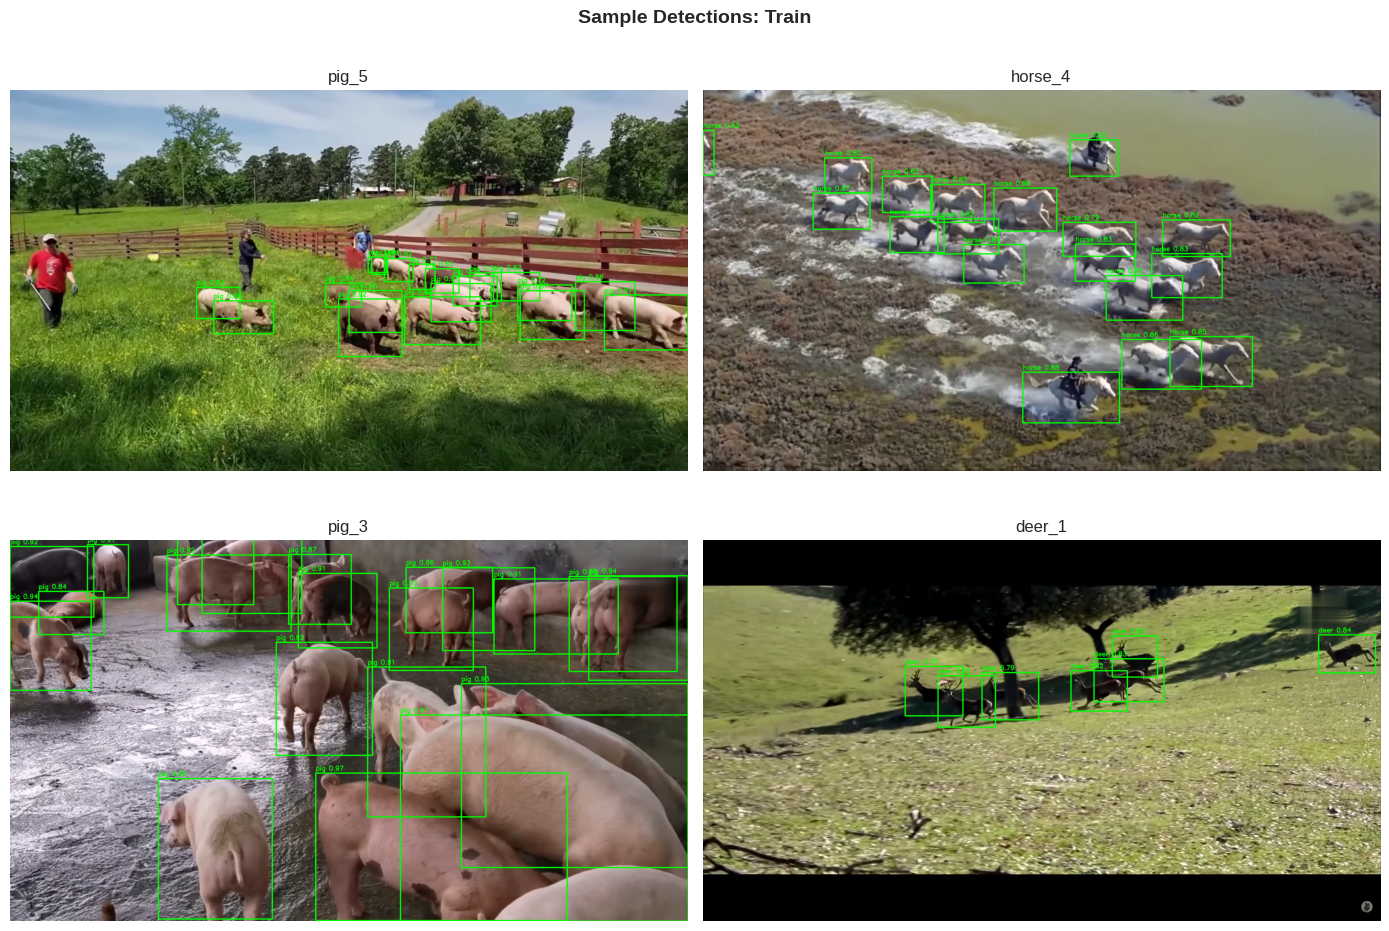

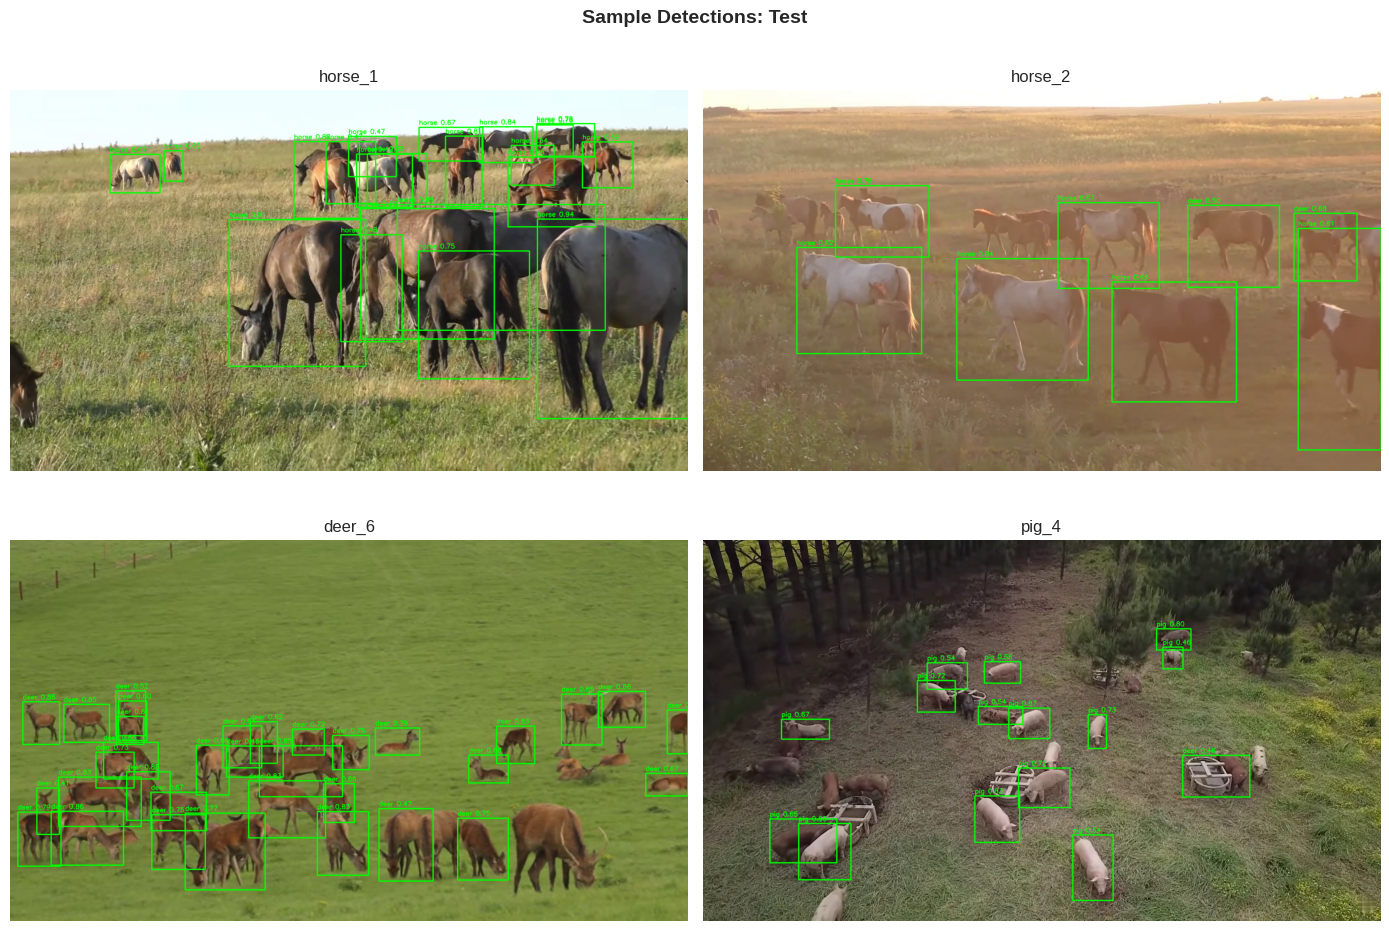

In [14]:
# Cell 14: Sample Detection Visualization
def show_samples(seq_dict, split_name, n=4):
    valid = [(k,v) for k,v in seq_dict.items() if v.get("video")]
    if not valid: return
    samples = random.sample(valid, min(n, len(valid)))
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Sample Detections: {split_name}', fontsize=14, fontweight='bold')
    for idx, (seq_name, paths) in enumerate(samples):
        ax = axes.flatten()[idx]
        cap = cv2.VideoCapture(paths["video"])
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(cap.get(cv2.CAP_PROP_FRAME_COUNT))//2)
        ret, frame = cap.read(); cap.release()
        if not ret: ax.text(0.5, 0.5, 'N/A', ha='center'); ax.axis('off'); continue
        results = det_model.predict(source=frame, imgsz=640, conf=0.4, verbose=False)
        for r in results:
            if r.boxes is None: continue
            for box in r.boxes:
                x1,y1,x2,y2 = map(int, box.xyxy[0].cpu().numpy())
                cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 3)
                cv2.putText(frame, f"{CLASS_NAMES.get(int(box.cls), 'unk')} {float(box.conf):.2f}", (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
        ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)); ax.set_title(seq_name); ax.axis('off')
    plt.tight_layout(); plt.savefig(os.path.join(OUTPUT_DIR, f'samples_{split_name}.png'), dpi=150); plt.show()

show_samples(train_seqs, "Train")
show_samples(test_seqs, "Test")

In [15]:
# Cell 15: Final Comprehensive Report
print("="*80)
print("WILDLIFE TRACKING PIPELINE - COMPREHENSIVE FINAL REPORT")
print("="*80)
print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print(f"\n{'─'*40}\n1. DATASET SUMMARY\n{'─'*40}")
print(f"  Training sequences: {len(train_seqs)}")
print(f"  Test sequences: {len(test_seqs)}")
print(f"  Classes: {NC} ({', '.join(CLASS_NAMES.values())})")

print(f"\n{'─'*40}\n2. TRACKING METHOD\n{'─'*40}")
print("""
  DETECTION: YOLOv8-nano (640x640)
  - Transfer learning from COCO pretrained weights
  - Chosen for optimal speed-accuracy balance
  
  TRACKING: Kalman Filter + Hungarian Algorithm
  - State: [x, y, area, aspect_ratio, vx, vy, v_area]
  - Constant velocity motion model
  - IoU-based cost matrix for data association
  
  OCCLUSION HANDLING:
  - Kalman Filter predicts through occlusions (up to 30 frames)
  - Track maintained using motion model prediction
  - Occlusion detected after 3+ consecutive misses
""")

if not metrics_df.empty:
    print(f"\n{'─'*40}\n3. TRACKING PERFORMANCE\n{'─'*40}")
    print(f"  Mean MOTA:              {metrics_df['MOTA'].mean():.4f}")
    print(f"  Mean Precision:         {metrics_df['precision'].mean():.4f}")
    print(f"  Mean Recall:            {metrics_df['recall'].mean():.4f}")
    print(f"  Avg Track Duration:     {metrics_df['avg_track_duration_pct'].mean():.1f}%")
    print(f"  Mostly Tracked (>80%):  {metrics_df['mostly_tracked'].sum()} objects")
    print(f"  Mostly Lost (<20%):     {metrics_df['mostly_lost'].sum()} objects")
    print(f"  Total ID Switches:      {metrics_df['IDsw'].sum()}")

if not performance_df.empty:
    print(f"\n{'─'*40}\n4. COMPUTATIONAL PERFORMANCE\n{'─'*40}")
    avg_fps = performance_df['avg_processing_fps'].mean()
    print(f"  Average FPS: {avg_fps:.1f}")
    print(f"  Real-time Capable: {'Yes' if avg_fps >= 30 else 'No'}")
    print(f"  Edge Device Ready: {'Yes' if avg_fps >= 15 else 'Needs optimization'}")

print(f"\n{'─'*40}\n5. FAILURE ANALYSIS\n{'─'*40}")
print("""
  COMMON FAILURES:
  1. Fast Motion - Large prediction errors
  2. Similar Appearances - ID switches when animals cross
  3. Long Occlusions - Track loss after 30+ frames
  4. Dense Groups - Confusion with multiple close animals
  
  MITIGATION:
  - Kalman Filter for motion prediction
  - IoU threshold 0.3 for flexible matching
  - 30-frame tolerance for occlusions
""")

print(f"\n{'─'*40}\n6. OUTPUT FILES\n{'─'*40}")
print(f"  Tracked videos: {OUTPUT_DIR}/*_tracked.mp4")
print(f"  Track data: {OUTPUT_DIR}/tracks.csv")
print(f"  Metrics: {OUTPUT_DIR}/tracking_metrics.csv")
print(f"  Performance: {OUTPUT_DIR}/performance.csv")
print(f"  Visualizations: {OUTPUT_DIR}/*.png")

print("\n" + "="*80)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)

WILDLIFE TRACKING PIPELINE - COMPREHENSIVE FINAL REPORT
Generated: 2025-12-11 16:51:52

────────────────────────────────────────
1. DATASET SUMMARY
────────────────────────────────────────
  Training sequences: 14
  Test sequences: 5
  Classes: 3 (deer, horse, pig)

────────────────────────────────────────
2. TRACKING METHOD
────────────────────────────────────────

  DETECTION: YOLOv8-nano (640x640)
  - Transfer learning from COCO pretrained weights
  - Chosen for optimal speed-accuracy balance
  
  TRACKING: Kalman Filter + Hungarian Algorithm
  - State: [x, y, area, aspect_ratio, vx, vy, v_area]
  - Constant velocity motion model
  - IoU-based cost matrix for data association
  
  OCCLUSION HANDLING:
  - Kalman Filter predicts through occlusions (up to 30 frames)
  - Track maintained using motion model prediction
  - Occlusion detected after 3+ consecutive misses


────────────────────────────────────────
3. TRACKING PERFORMANCE
────────────────────────────────────────
  Mean MOTA: 